# Netflix Lasso Regression Model

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_absolute_error, mean_squared_error,  r2_score, explained_variance_score

## Loading Netflix Dataset

In [2]:
df = pd.read_csv('Netflix.csv')
df.head()

,Date,Profile Name,Title,Type,Genre,Duration Seconds,Device Type
0,2013-12-29,Sharleen,Jackass: The Movie,Movie,Comedy,23,Apple TV 3 (revised)
1,2013-12-29,Sharleen,Runaway Bride,Movie,Romantic-Comedy,3610,Apple TV 3 (revised)
2,2013-12-29,Sharleen,The Benchwarmers,Movie,Comedy,4696,Apple TV 3 (revised)
3,2013-12-29,Sharleen,This Means War,Movie,Romantic-Comedy,362,Apple TV 3 (revised)
4,2014-01-01,Sharleen,Bloodline,Show,Thriller,1168,Bell Canada Mediaroom Bell Canada Mediaroom


## Filtering & Cleaning the Data

##### I will first look for nulls in the dataset before to make sure there are no empty rows for the analysis

In [3]:
df.isnull().sum()

Date                0
Profile Name        0
Title               0
Type                0
Genre               0
Duration Seconds    0
Device Type         0
dtype: int64

##### Then I will look for the data types to see if any need to be changed

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8452 entries, 0 to 8451
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              8452 non-null   object
 1   Profile Name      8452 non-null   object
 2   Title             8452 non-null   object
 3   Type              8452 non-null   object
 4   Genre             8452 non-null   object
 5   Duration Seconds  8452 non-null   int64 
 6   Device Type       8452 non-null   object
dtypes: int64(1), object(6)
memory usage: 462.3+ KB


##### Changing the text columns to category fields from objects:

In [5]:
df[['Profile Name','Title','Type','Genre','Device Type']] = df[['Profile Name','Title','Type','Genre','Device Type']].astype('category')

##### Then altering the 'Date' column so that the year, month, and day are separated and moved to the beginning of the dataframe to improve the analyis

In [6]:
df['Date'] = pd.to_datetime(df['Date']) #passing through the 'datetime' type

In [7]:
df['Year'] = df['Date'].dt.year #taking the year from the 'Date' column and creating a column of it's own
df['Month'] = df['Date'].dt.month #taking the month from the 'Date' column and creating a column of it's own
df['Day'] = df['Date'].dt.day #taking the day from the 'Date' column and creating a column of it's own

In [8]:
cols = ['Year', 'Month', 'Day'] + [col for col in df.columns if col not in ['Year', 'Month', 'Day']] #telling the df to place the new columns at the 
df = df[cols]                                                                                  

In [9]:
df = df.drop(columns = 'Date') # dropping the column 'Date' once we have the new columns

##### For easier analysis, I will now conver the 'Duration Seconds' column to minutes so the visuals will be easier to read

In [10]:
df['Minutes'] = df['Duration Seconds'] / 60 #dividing the total seconds by 60 to get back a new column with the total minutes
df = df.drop(columns='Duration Seconds') #dropping the 'Duration Seconds' column
df

,Year,Month,Day,Profile Name,Title,Type,Genre,Device Type,Minutes
0,2013,12,29,Sharleen,Jackass: The Movie,Movie,Comedy,Apple TV 3 (revised),0.383333
1,2013,12,29,Sharleen,Runaway Bride,Movie,Romantic-Comedy,Apple TV 3 (revised),60.166667
2,2013,12,29,Sharleen,The Benchwarmers,Movie,Comedy,Apple TV 3 (revised),78.266667
3,2013,12,29,Sharleen,This Means War,Movie,Romantic-Comedy,Apple TV 3 (revised),6.033333
4,2014,1,1,Sharleen,Bloodline,Show,Thriller,Bell Canada Mediaroom Bell Canada Mediaroom,19.466667
...,...,...,...,...,...,...,...,...,...
8447,2024,10,16,Brette,Monsters,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,91.133333
8448,2024,10,17,Brette,Monsters,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,82.900000
8449,2024,10,18,Brette,Monsters,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,33.966667
8450,2024,10,18,Brette,The Menendez Brothers,Movie,Documentary,Netflix Chrome MAC (Cadmium) HTML 5,0.533333


##### The last step to cleaning the data is dropping the 'Title' column so the Lasso Regression will be able to read the dataframe more easily

In [11]:
df = df.drop(columns='Title') #Dropping the column 'Title' from the dataframe and passing through to the dataframe
df

,Year,Month,Day,Profile Name,Type,Genre,Device Type,Minutes
0,2013,12,29,Sharleen,Movie,Comedy,Apple TV 3 (revised),0.383333
1,2013,12,29,Sharleen,Movie,Romantic-Comedy,Apple TV 3 (revised),60.166667
2,2013,12,29,Sharleen,Movie,Comedy,Apple TV 3 (revised),78.266667
3,2013,12,29,Sharleen,Movie,Romantic-Comedy,Apple TV 3 (revised),6.033333
4,2014,1,1,Sharleen,Show,Thriller,Bell Canada Mediaroom Bell Canada Mediaroom,19.466667
...,...,...,...,...,...,...,...,...
8447,2024,10,16,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,91.133333
8448,2024,10,17,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,82.900000
8449,2024,10,18,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,33.966667
8450,2024,10,18,Brette,Movie,Documentary,Netflix Chrome MAC (Cadmium) HTML 5,0.533333


##### Now that the new columns are created and the dtypes are properly set, I will filter the dataframe so that it is just data from my Netflix account

The below code is passing a filtered dataframe with only rows that contain the profile name 'Brette' to the original dataframe

In [12]:
df = df[df['Profile Name'] == 'Brette']

#### Now the final dataframe is ready for analysis

In [13]:
df 

,Year,Month,Day,Profile Name,Type,Genre,Device Type,Minutes
157,2014,3,10,Brette,Show,Drama-Comedy,PC,30.766667
158,2014,3,10,Brette,Movie,Drama,PC,0.133333
160,2014,3,11,Brette,Show,Drama-Comedy,PC,39.633333
162,2014,3,13,Brette,Show,Horror,Apple TV 3 (revised),90.516667
165,2014,3,14,Brette,Show,Horror,Apple TV 3 (revised),206.400000
...,...,...,...,...,...,...,...,...
8444,2024,10,15,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,183.916667
8447,2024,10,16,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,91.133333
8448,2024,10,17,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,82.900000
8449,2024,10,18,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,33.966667


#### Graphs that represent the data 

##### The below code is grouping the total minutes by each category field for better visual representation of the data

In [14]:
# Summarize the data
df_summed_genre = df.groupby('Genre', observed=True)['Minutes'].sum().reset_index() #Grouping the genres by the total minutes watched
df_summed_type = df.groupby('Type', observed=True)['Minutes'].sum().reset_index() #Grouping the types movie and show by the total minutes watched
df_summed_devices = df.groupby('Device Type', observed=True)['Minutes'].sum().reset_index() #Grouping the devices used by total minutes watched
df_summed_years = df.groupby('Year', observed=True)['Minutes'].sum().reset_index() #Grouping each year by the total minutes watched
top_3_devices = df_summed_devices.nlargest(3, 'Minutes') #Taking the group by above and filtering it to show the top 3

##### Now that we have the formulas, I will insert these into matplotlib graphs to visually represent the data

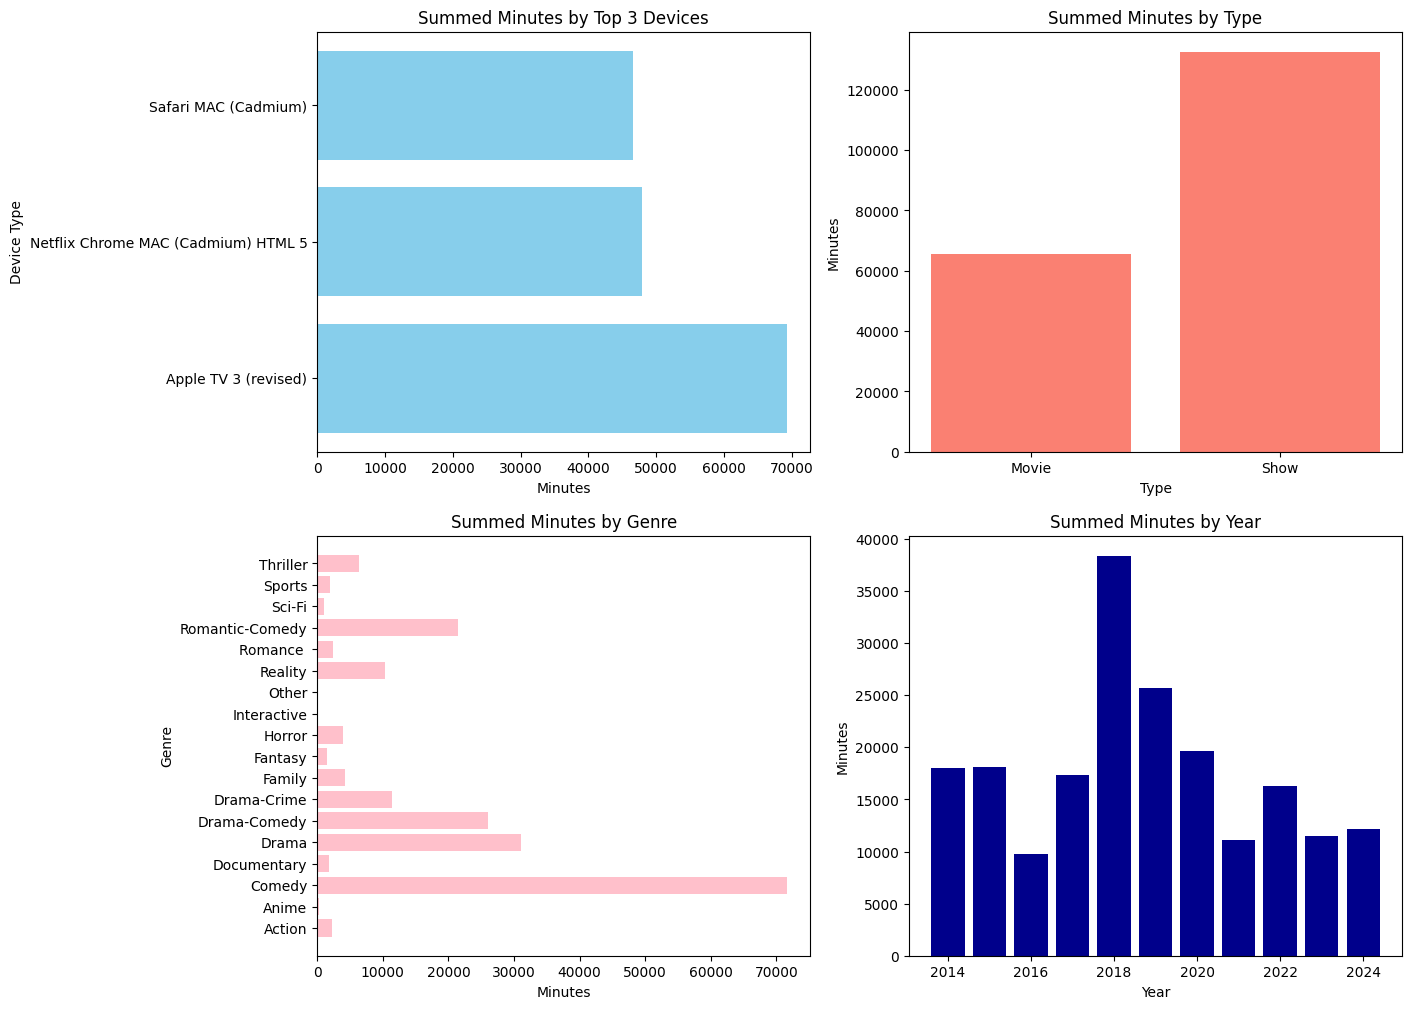

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12)) 

# Plot for the summed minutes by the top 3 devices used by 'Brettes' profile
axes[0, 0].barh(top_3_devices['Device Type'], top_3_devices['Minutes'], color='skyblue') 
axes[0, 0].set_title('Summed Minutes by Top 3 Devices')
axes[0, 0].set_xlabel('Minutes')
axes[0, 0].set_ylabel('Device Type')

# Plot for the summed minutes by each genre
axes[1, 0].barh(df_summed_genre['Genre'], df_summed_genre['Minutes'], color='pink')
axes[1, 0].set_title('Summed Minutes by Genre')
axes[1, 0].set_xlabel('Minutes')
axes[1, 0].set_ylabel('Genre')

# Plot for the summed minutes by both show and movies types
axes[0, 1].bar(df_summed_type['Type'], df_summed_type['Minutes'], color='salmon')
axes[0, 1].set_title('Summed Minutes by Type')
axes[0, 1].set_xlabel('Type')
axes[0, 1].set_ylabel('Minutes')

# Plot for the summed minutes by each year
axes[1, 1].bar(df_summed_years['Year'], df_summed_years['Minutes'], color='darkblue')
axes[1, 1].set_title('Summed Minutes by Year')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Minutes')

plt.show();

## Beginning Analysis

##### To begin the analysis, I will split the dataframe in to X and y for the train test split below

In [16]:
X = df.drop(columns='Minutes',axis=1) #dropping the 'Minutes' column from the dataframe for the y variable
X #X is a 2D feature shown as a pandas dataframe

,Year,Month,Day,Profile Name,Type,Genre,Device Type
157,2014,3,10,Brette,Show,Drama-Comedy,PC
158,2014,3,10,Brette,Movie,Drama,PC
160,2014,3,11,Brette,Show,Drama-Comedy,PC
162,2014,3,13,Brette,Show,Horror,Apple TV 3 (revised)
165,2014,3,14,Brette,Show,Horror,Apple TV 3 (revised)
...,...,...,...,...,...,...,...
8444,2024,10,15,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5
8447,2024,10,16,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5
8448,2024,10,17,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5
8449,2024,10,18,Brette,Show,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5


In [17]:
y = df['Minutes'] #passing through the 'Minutes' column to the y variable
y #turning it into a single feature

157      30.766667
158       0.133333
160      39.633333
162      90.516667
165     206.400000
           ...    
8444    183.916667
8447     91.133333
8448     82.900000
8449     33.966667
8450      0.533333
Name: Minutes, Length: 3335, dtype: float64

##### Before beginning the model, since X is made up mostly of categories we can use a one hot encoder to turn the categories into an easier to read format for the Lasso machine learning model

In [18]:
X = pd.get_dummies(X, drop_first=True) #Analyzing True or False for row in the dataframe, showing if it is present in the X dataframe
X

,Year,Month,Day,Profile Name_Chase,Profile Name_Sharleen,Type_Show,Genre_Anime,Genre_Comedy,Genre_Documentary,Genre_Drama,...,Device Type_PC,Device Type_Roku Athens Smart TV,Device Type_SEI Robotics SEI800ESTL MVPD STB,Device Type_Safari MAC (Cadmium),Device Type_Samsung CE 2021 Kant-S2e UHD TV Smart TV,Device Type_Sony PS3,Device Type_Sony PS4,Device Type_TiVo EL Series-6 Scaling Platform MVPD STB,Device Type_TiVo Eastlink Smartbox Qi3 Set Top Box,Device Type_iPhone 12 Pro
157,2014,3,10,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
158,2014,3,10,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
160,2014,3,11,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
162,2014,3,13,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
165,2014,3,14,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8444,2024,10,15,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8447,2024,10,16,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8448,2024,10,17,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8449,2024,10,18,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Train Test Split

##### The X and y data is now ready to be passed through the train test split to ensure the data is not overloaded and our machine learning algorithm can better predit in the model

X_train and X_test will remain 2D and y_train and y_test will be taken from the 1D column we created above
For this train test split, we will be using a test size of 30% vs 70% and a random state of 42

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

##### Now that the train variables are set, we can pass the 2D X variables through a scaler that will help normalize the data in the Lasso regression model

In [20]:
scaler = StandardScaler()

scaler.fit(X_train) #fitting the X_train to the scaler

X_train = scaler.transform(X_train) #transforming the 2D variables into arrays
X_test = scaler.transform(X_test)

In [21]:
X_train, X_test

(array([[ 0.87783403, -1.45024532,  0.0531882 , ...,  0.        ,
          0.        , -0.10405382],
        [ 1.23810564,  1.00745849,  0.74800867, ...,  0.        ,
          0.        , -0.10405382],
        [ 0.87783403,  0.39303254, -0.75743568, ...,  0.        ,
          0.        , -0.10405382],
        ...,
        [-0.20298079, -1.14303234,  0.74800867, ...,  0.        ,
          0.        , -0.10405382],
        [-0.92352401,  1.00745849,  0.28479502, ...,  0.        ,
          0.        , -0.10405382],
        [ 1.59837725,  1.31467147,  0.51640185, ...,  0.        ,
          0.        , -0.10405382]]),
 array([[ 0.15729082, -0.22139341,  0.16899161, ...,  0.        ,
          0.        , -0.10405382],
        [ 0.87783403,  0.70024552, -1.33645274, ...,  0.        ,
          0.        ,  9.61041102],
        [ 0.15729082, -1.14303234, -0.52582886, ...,  0.        ,
          0.        , -0.10405382],
        ...,
        [ 0.15729082, -0.52860639, -0.75743568, ...,  

## Lasso Regression Model

##### Below I am defining the model as the Lasso Regression Machine Learning module
##### I chose the Lasso model to prevent over-fitting the dataframe since there is such a wide variety of variables and predictons in the dataframe
##### The Lasso model can also set certain coefficients to zero that are irrelevant to the Netflix dataframe for a more interpretable model

In [22]:
mdl = Lasso(fit_intercept=True)
mdl #Passing fit_intercept true so the model knows to calculate the linear regression intercepts

Lasso()

In [23]:
mdl.fit(X_train,y_train) #Fitting the train test split we did above to the Lasso machine learning model

Lasso()

##### Now we can create the predictions from the model, we can pass through the X_test variable so we will be able to compare it to the y_test array that are the target values

In [24]:
y_hat = mdl.predict(X_test) #passing the predictions for X_test into y_hat for the scores we will calculate
y_hat

array([80.18149372, 28.962406  , 56.0232057 , ..., 34.39243496,
       59.68205044, 77.7417664 ])

In [25]:
len(y_test), len(y_hat) #double checking to see that the lengths of both y_hat and y_test match since it is necessary for the analysis

(1001, 1001)

##### Now that the model is fitted, we can begin to analyze the data, below are calculations for the mean, median, and standard deviation of the dataset

In [26]:
df['Minutes'].mean(), df['Minutes'].median(), df['Minutes'].std()

(59.38996501749125, 44.43333333333333, 53.63836043517184)

##### Creating the minimum, maximum and range variables for our scores

In [27]:
ymin = np.min(y_test) #finding the min max and range of y_test (knowing the base units)
ymax = np.max(y_test)
yrange = (np.max(y_test) - np.min(y_test))
# Establish the base units to compare the resultant metrics  ....
ymin, ymax, yrange

(0.016666666666666666, 364.8833333333333, 364.8666666666667)

##### Mean absolute error score

In [28]:
mae = mean_absolute_error(y_test,y_hat)
print(f'An MAE of {mae:.3} means the avg prediction error is about {mae / yrange * 100:.3}% of the total range of y_test.')

An MAE of 37.4 means the avg prediction error is about 10.3% of the total range of y_test.


##### Mean squared error score

In [29]:
mse = mean_squared_error(y_test, y_hat) #the mean squared error that is reported in square units that we will use for the rmse calculation
print(f'The mse is {mse}')

The mse is 2486.1075698225


##### Square root of the mean squared error score

In [30]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print(f'An RMSE of {rmse:.3} means the avg prediction error is about {rmse / yrange * 100:.3}% of the total range of y_test.')

An RMSE of 49.9 means the avg prediction error is about 13.7% of the total range of y_test.


##### The r-squared score of the Lasso regression model

In [31]:
rsq = r2_score(y_test, y_hat)
print(f'An r-square score of {rsq:.5} means approx {rsq * 100:.3}% in the actual (y_test) values is explained by the predicted (y-hat) values.\nThe remaining {(1-rsq) * 100:.3} of the variance is due to unknown factors (i.e. factors not captured by the model). ') 

An r-square score of 0.092022 means approx 9.2% in the actual (y_test) values is explained by the predicted (y-hat) values.
The remaining 90.8 of the variance is due to unknown factors (i.e. factors not captured by the model). 


##### Adjusted score of the Lasso regression model

In [32]:
r_squ = r2_score(y_test, y_hat) #passing the r-squared percentage in that we just created above
n = len(y) #the number of objects in the y variable
k = X.shape[1] #the shape of x that is the number of predictors
adj_rsq = 1 - (1 - r_squ) * (n - 1) / (n - k - 1)
adj_rsq

0.0731178591797167

##### Creating a dataframe to view how the model predicted against the actual results in the original dataframe

In [33]:
yhat_df = pd.DataFrame({'Actuals':y_test, 'Preds': y_hat})
yhat_df['Diff'] = np.abs(yhat_df['Actuals'] - yhat_df['Preds'])
yhat_df['Residuals'] = yhat_df['Actuals'] - yhat_df['Preds']
yhat_df

,Actuals,Preds,Diff,Residuals
4829,23.666667,80.181494,56.514827,-56.514827
6710,7.683333,28.962406,21.279073,-21.279073
4381,7.350000,56.023206,48.673206,-48.673206
7746,12.550000,67.872123,55.322123,-55.322123
271,90.566667,71.048415,19.518251,19.518251
...,...,...,...,...
1078,131.750000,58.205364,73.544636,73.544636
4917,101.883333,71.751489,30.131845,30.131845
4667,3.116667,34.392435,31.275768,-31.275768
535,41.283333,59.682050,18.398717,-18.398717


##### Analyzing the mean of the dataframe we created above

In [34]:
yhat_df.mean() 

Actuals      57.302048
Preds        60.350057
Diff         37.425554
Residuals    -3.048009
dtype: float64

##### Visualizing the dataframe we created above
##### There are many outliers in the boxplots showing the many duration minutes in the data
##### The histplot shows that most of the prediction residuals were off by negative values
##### The scatter plot shows the residuals were between mostly -100 and 100

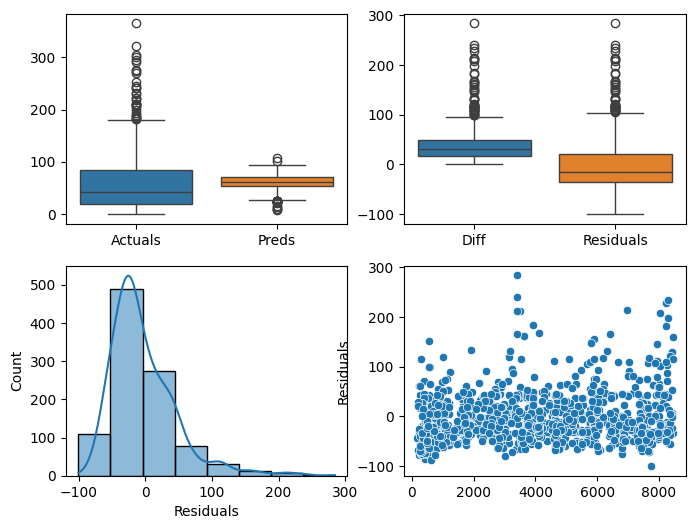

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
sns.boxplot(data=yhat_df[['Actuals','Preds']], ax=axes[0,0])
sns.boxplot(data=yhat_df[['Diff','Residuals']], ax=axes[0,1])
sns.histplot(data=yhat_df['Residuals'], kde=True,bins=8, ax=axes[1,0])
sns.scatterplot(data=yhat_df['Residuals'], ax=axes[1,1])
plt.show()

##### Calculating the coefficients in the model for the intercept

In [36]:
mdl.coef_[0]

0.21356325780469512

##### Calculating the actual intercept for the linear model

In [37]:
mdl.intercept_

60.28542559268781

##### Passing the coefficient variables and intercept into m and b for the formula below

In [38]:
m = mdl.coef_[0]

b = mdl.intercept_

m, b

(0.21356325780469512, 60.28542559268781)

##### The formula for the linear regression using the Lasso machine learning module: 

In [39]:
print("formula: y = {:.2f}x + {:.2f}".format(m,b))

formula: y = 0.21x + 60.29


## Visualizing the model

##### You can see by the below graph the the data is not normally distributed as the red line presents a noraml distribution
##### Given that there aren't many correlations in the dataset between all the different genres and shows I have watched

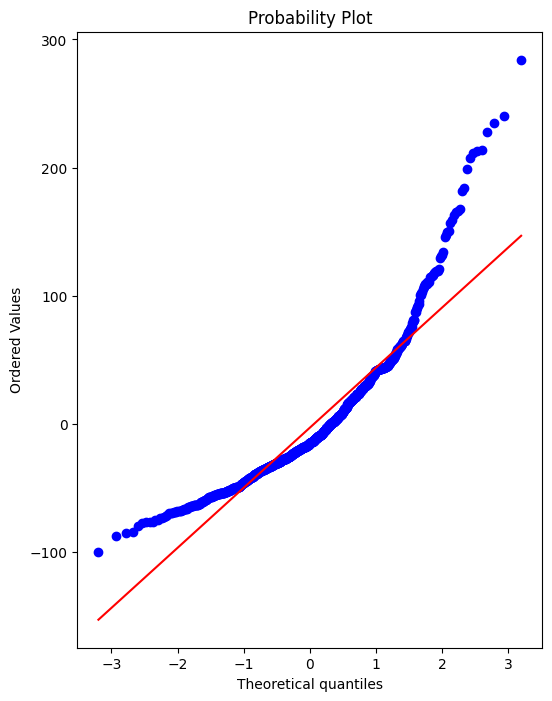

In [40]:
fig,ax = plt.subplots(figsize=(6,8))
sp.stats.probplot(yhat_df['Residuals'], plot=ax)
# red line represent a perfect normal distribution
plt.show()

In [41]:
print(f"{r2_score(y_test, y_hat) * 100:.2f}% of the variability in the dependent variable is explainded by the independant variable")

9.20% of the variability in the dependent variable is explainded by the independant variable


## Summary

Through the analysis we have found that the dataframe is not normalized, and that there is a wide variety with little correlation between each category and the total minutes watched. Since I have watched a wide variety of shows and movies this was the expected outcome of the Lasso regression model.